In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_data_4barplot(list_files):
    df_all = pd.DataFrame()
    for file_name in list_files:
        dbst = file_name[:-(len(file_pattern)+1)]
        if dbst=="":
            dbst="GENE"
        # read the CSV file into a pandas dataframe
        df_cv = pd.read_csv(DIR+file_name, index_col=0)
        # extract the first row of the dataframe
        avg_row = df_cv.iloc[0]
        sd_row = df_cv.iloc[1]
        df_avgsd = pd.DataFrame(columns=df_cv.columns)
        df_avgsd = df_avgsd.append(avg_row, ignore_index=False)
        df_avgsd["best_avgAUC"]=avg_row.max() # collect best model avg AUC
        df_avgsd["best_model"]=avg_row.idxmax() # collect best model name
        df_avgsd["best_sdAUC"]= sd_row[avg_row.idxmax()]# collect best model sd AUC
        df_avgsd.index=[dbst]
        # append the second dataframe to the overall dataframe
        df_all = pd.concat([df_all, df_avgsd], axis=0)
    # replace model names
    df_all=df_all.replace({'RandomForest': 'Random Forest', 'linearSVM': 'SVM Linear', 'RBFSVM': 'SVM Radial', 'LogisticRegression': 'Logistic Regression', 'GradientBoosting': 'Gradient Boosting'})
    df_all.columns = ["SVM Linear", "SVM Radial", "Random Forest", "Gradient Boosting", "Adaboost", "Logistic Regression", "best_avgAUC", "best_model", "best_sdAUC"]
    df_all = df_all[["Random Forest", "Logistic Regression", "SVM Linear", "SVM Radial", "Gradient Boosting", "Adaboost", "best_avgAUC", "best_model", "best_sdAUC"]]
    # generate dataframe with db and st values in appropriate format
    dbst_df = pd.DataFrame(index=df_all.index.str.split("_").str[1].unique().dropna()) # remove gene row
    dbs=[db for db in df_all.index.str.split("_").str[0].unique().dropna() if db != "GENE"]

    for db in dbs:
        temp_df = df_all.loc[df_all.index.str.split("_").str[0] == db, ['best_avgAUC', 'best_model', 'best_sdAUC']]
        temp_df.columns = [temp_df.index[i].split("_")[0] + "_" + col.split("_")[1] for i, col in enumerate(temp_df.columns)]
        temp_df.index=temp_df.index.str.split("_").str[1].unique().dropna()

        
        # append the current dataframe to the new dataframe
        dbst_df = pd.concat([dbst_df, temp_df], axis=1)

    # generate gene-level data in appropriate format
    gene_df = df_all.loc["GENE", ['best_avgAUC', 'best_model', 'best_sdAUC']]
    gene_df = gene_df.rename({'best_avgAUC': 'GENE_avgAUC', 'best_model': 'GENE_model', 'best_sdAUC': 'GENE_sdAUC'})
    return(dbst_df, gene_df)

In [4]:
def generate_barplot(dbst_df, gene_df, savefig=True, path="./", name=None):
    agg = dbst_df.index.tolist()
    agg.append("single features")
    x_axis = np.arange(len(dbst_df.index))

    fig, ax = plt.subplots(figsize=(9, 8))
    bars = []
    bars.append(ax.bar(
        x_axis - 0.3, dbst_df['GOBP_avgAUC'], 0.3, tick_label=dbst_df.index, label="GOBP features",
        edgecolor='k', linewidth=2))
    bars.append(ax.bar(
        x_axis, dbst_df['GOCC_avgAUC'], 0.3,
        tick_label=dbst_df.index, label="GOCC features",
        edgecolor='k', linewidth=2))
    bars.append(ax.bar(
        x_axis + 0.3, dbst_df['CORUM_avgAUC'], 0.3, tick_label=dbst_df.index,
        label="CORUM features", edgecolor='k', linewidth=2))
    bars.append(ax.bar(
        x_axis[-1] + 0.8, gene_df['GENE_avgAUC'], 0.3, tick_label="GENE",
        label="GENE features", edgecolor='k', linewidth=2))

    for bar_group in bars:
        db=bar_group.get_label().split(" ")[0]
        for j, bar in enumerate(bar_group):
            if db != "GENE":
                ax.text(bar.get_x() + bar.get_width() / 2, 0.3, dbst_df[db + '_model'][j], color='white', ha='center', va='center', fontweight='bold', rotation=90)
                #ax.text(x_axis[-1] + 0.8, 0.3 , gene_df['best_model'], color='white', ha='center', fontweight='bold', va='center', rotation=90)
            else:
                ax.text(bar.get_x() + bar.get_width() / 2, 0.3, gene_df[db + '_model'], color='white', ha='center', va='center', fontweight='bold', rotation=90)

    ax.errorbar(
        x_axis - 0.3, dbst_df['GOBP_avgAUC'], yerr=dbst_df['GOBP_sdAUC'],
        fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
        ms=4, capsize=5)
    ax.errorbar(
        x_axis, dbst_df['GOCC_avgAUC'], yerr=dbst_df['GOCC_sdAUC'],
        fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
        ms=4, capsize=5)
    ax.errorbar(
        x_axis + 0.3, dbst_df['CORUM_avgAUC'], yerr=dbst_df['CORUM_sdAUC'],
        fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
        ms=4, capsize=5)
    ax.errorbar(
        x_axis[-1] + 0.8, gene_df['GENE_avgAUC'], yerr=gene_df['GENE_sdAUC'],
        fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
        ms=4, capsize=5)

    ax.set_xticks(np.append(x_axis, 4.8))
    ax.set_xticklabels(agg)
    ax.set_ylabel('Average 10-folds AUC')       # Label on Y axis
    ax.set_ylim((0, 1))
    plt.legend()
    if savefig==True:
        if not name:
            name="Barplot_AUC_DBvsST_BL.pdf"
        plt.savefig(path + name)
    plt.show()


/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_51793/4176638928.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avgsd = df_avgsd.append(avg_row, ignore_index=False)
/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_51793/4176638928.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avgsd = df_avgsd.append(avg_row, ignore_index=False)
/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_51793/4176638928.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avgsd = df_avgsd.append(avg_row, ignore_index=False)
/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_51793/4176638928.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

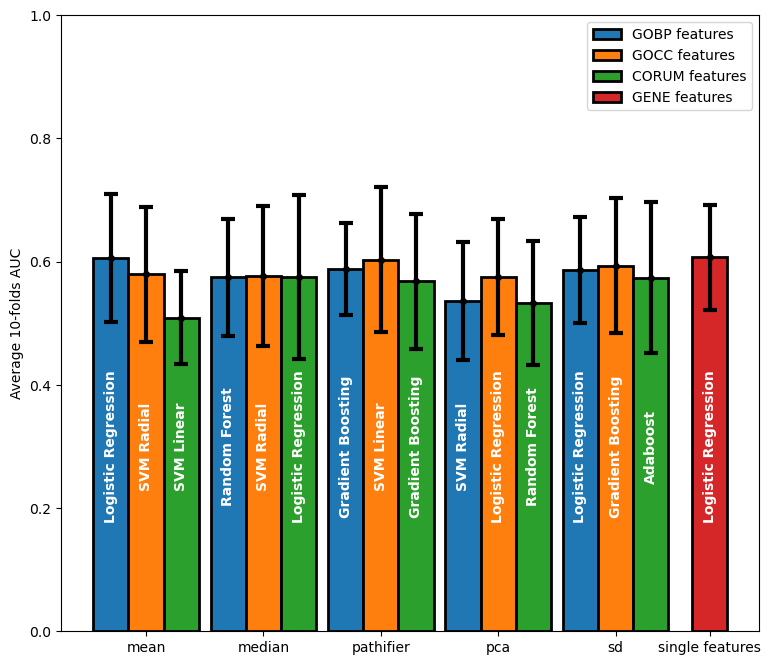

In [10]:
DIR = 'BL-UPDRS3/results/'
list_files = os.listdir(DIR)
list_files.sort()
file_pattern = 'results_nestedCV_UPDRS3_binary.csv'
list_files = [file for file in list_files if file_pattern in file]
df_agg, df_gene = generate_data_4barplot(list_files)
generate_barplot(df_agg, df_gene, savefig=True, path="../reports/PRED-BL-TS-UPDRS3_results/plots/", name="Barplot_AUC_DBvsST_BL_asdf.pdf")

In [13]:
DIR = 'TS-UPDRS3/results/'
list_files = os.listdir(DIR)
list_files.sort()
file_pattern = 'lm-time_results_nestedCV_UPDRS3_binary.csv'
list_files = [file for file in list_files if file_pattern in file]
list_files

['CORUM_mean_lm-time_results_nestedCV_UPDRS3_binary.csv',
 'CORUM_median_lm-time_results_nestedCV_UPDRS3_binary.csv',
 'CORUM_pathifier_lm-time_results_nestedCV_UPDRS3_binary.csv',
 'CORUM_pca_lm-time_results_nestedCV_UPDRS3_binary.csv',
 'CORUM_sd_lm-time_results_nestedCV_UPDRS3_binary.csv',
 'GOBP_mean_lm-time_results_nestedCV_UPDRS3_binary.csv',
 'GOBP_median_lm-time_results_nestedCV_UPDRS3_binary.csv',
 'GOBP_pathifier_lm-time_results_nestedCV_UPDRS3_binary.csv',
 'GOBP_pca_lm-time_results_nestedCV_UPDRS3_binary.csv',
 'GOBP_sd_lm-time_results_nestedCV_UPDRS3_binary.csv',
 'GOCC_mean_lm-time_results_nestedCV_UPDRS3_binary.csv',
 'GOCC_median_lm-time_results_nestedCV_UPDRS3_binary.csv',
 'GOCC_pathifier_lm-time_results_nestedCV_UPDRS3_binary.csv',
 'GOCC_pca_lm-time_results_nestedCV_UPDRS3_binary.csv',
 'GOCC_sd_lm-time_results_nestedCV_UPDRS3_binary.csv']

/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_51793/4176638928.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avgsd = df_avgsd.append(avg_row, ignore_index=False)
/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_51793/4176638928.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avgsd = df_avgsd.append(avg_row, ignore_index=False)
/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_51793/4176638928.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avgsd = df_avgsd.append(avg_row, ignore_index=False)
/var/folders/w6/l9gj7l857lsg21_b5grk8xpxhtd5y4/T/ipykernel_51793/4176638928.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

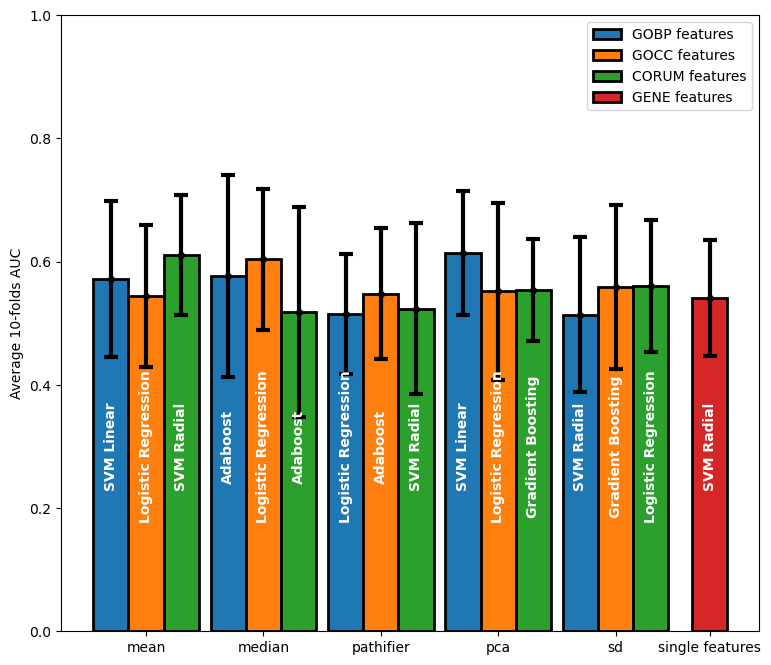

In [17]:
DIR = 'TS-UPDRS3/results/'
list_files = os.listdir(DIR)
list_files.sort()
file_pattern = 'sd_results_nestedCV_UPDRS3_binary.csv'
list_files = [file for file in list_files if file_pattern in file]
df_agg, df_gene = generate_data_4barplot(list_files)
generate_barplot(df_agg, df_gene, savefig=True, path="../reports/PRED-BL-TS-UPDRS3_results/plots/", name="Barplot_AUC_DBvsST_TS-SD.pdf")

In [41]:
df_all

,Random Forest,Logistic Regression,SVM Linear,SVM Radial,Gradient Boosting,Adaboost,best_avgAUC,best_model,best_sdAUC
CORUM_mean,0.542711,0.533166,0.605064,0.540639,0.635957,0.566176,0.635957,Logistic Regression,0.079787
CORUM_median,0.512007,0.547170,0.522861,0.517472,0.568026,0.511258,0.568026,Logistic Regression,0.054084
CORUM_pathifier,0.579643,0.570477,0.620048,0.574368,0.608200,0.564750,0.620048,SVM Linear,0.103540
CORUM_pca,0.544672,0.498953,0.542293,0.542736,0.587684,0.484952,0.587684,Logistic Regression,0.082087
CORUM_sd,0.606874,0.610971,0.656684,0.589550,0.669920,0.613592,0.669920,Logistic Regression,0.064123
GOBP_mean,0.638614,0.629178,0.632651,0.639639,0.664611,0.573229,0.664611,Logistic Regression,0.084995
GOBP_median,0.569814,0.555531,0.594313,0.543405,0.608434,0.541449,0.608434,Logistic Regression,0.059689
GOBP_pathifier,0.576638,0.565982,0.607537,0.555242,0.600925,0.549554,0.607537,SVM Linear,0.062537
GOBP_pca,0.595613,0.548669,0.564121,0.597869,0.593349,0.501223,0.597869,Adaboost,0.066604
GOBP_sd,0.571020,0.598663,0.600875,0.561174,0.605905,0.551977,0.605905,Logistic Regression,0.110485


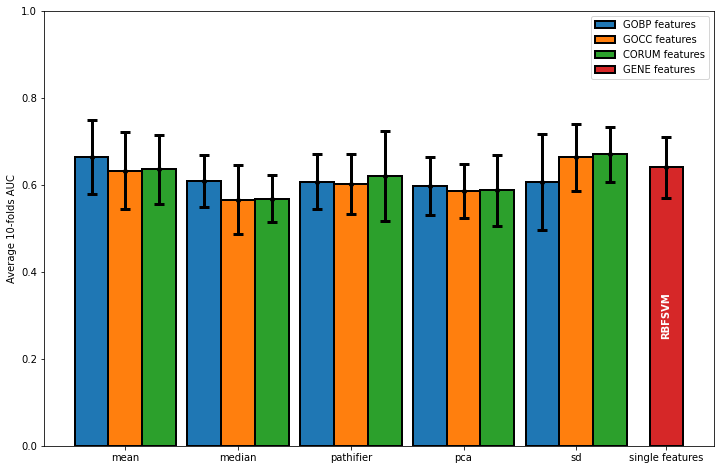

In [286]:
agg = dbst_df.index.tolist()
agg.append("single features")
x_axis = np.arange(len(dbst_df.index))

fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(
    x_axis - 0.3, dbst_df['GOBP_avgAUC'], yerr=dbst_df['GOBP_sdAUC'],
    fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
    ms=4, capsize=5)
ax.errorbar(
    x_axis, dbst_df['GOCC_avgAUC'], yerr=dbst_df['GOCC_sdAUC'],
    fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
    ms=4, capsize=5)
ax.errorbar(
    x_axis + 0.3, dbst_df['CORUM_avgAUC'], yerr=dbst_df['CORUM_sdAUC'],
    fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
    ms=4, capsize=5)
ax.errorbar(
    x_axis[-1] + 0.8, gene_df['GENE_avgAUC'], yerr=gene_df['GENE_sdAUC'],
    fmt='o', color='Black', elinewidth=3, capthick=3, errorevery=1, alpha=1,
    ms=4, capsize=5)
ax.bar(
    x_axis - 0.3, dbst_df['GOBP_avgAUC'], 0.3, tick_label=dbst_df.index, label="GOBP features",
    edgecolor='k', linewidth=2)
ax.bar(
    x_axis, dbst_df['GOCC_avgAUC'], 0.3,
    tick_label=dbst_df.index, label="GOCC features",
    edgecolor='k', linewidth=2)
ax.bar(
    x_axis + 0.3, dbst_df['CORUM_avgAUC'], 0.3, tick_label=dbst_df.index,
    label="CORUM features", edgecolor='k', linewidth=2)
ax.bar(
    x_axis[-1] + 0.8, gene_df['GENE_avgAUC'], 0.3, tick_label="GENE",
    label="GENE features", edgecolor='k', linewidth=2)
#ax.text(x_axis - 0.3, 0.3 , dbst_df['GOBP_model'], color='white', ha='center', fontweight='bold', va='center', rotation=90)
#ax.text(x_axis, 0.3 , dbst_df['GOCC_model'], color='white', ha='center', fontweight='bold', va='center', rotation=90)
#ax.text(x_axis + 0.3, 0.3 , dbst_df['CORUM_model'], color='white', ha='center', fontweight='bold', va='center', rotation=90)
ax.text(x_axis[-1] + 0.8, 0.3 , gene_df['GENE_model'], color='white', ha='center', fontweight='bold', va='center', rotation=90)
ax.set_xticks(np.append(x_axis, 4.8))
ax.set_xticklabels(agg)
ax.set_ylabel('Average 10-folds AUC')       # Label on Y axis
ax.set_ylim((0, 1))
plt.legend()
#plt.savefig(dir_results + "cv_performance_DBvsST.pdf")
plt.show()


<AxesSubplot:>

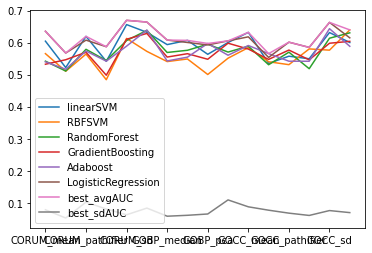

In [288]:
df_all.plot()